5-7. 프로젝트: Spectrogram classification 모델 구현
그래서 오늘은 방금 든 궁금증을 해결해 보는 것으로 프로젝트를 진행해 봅니다.

오늘 실습에서 1차원 Waveform 데이터를 입력받아 Text 라벨을 출력하는 모델을 기본 버전과 Skip-connection 버전으로 나누어 학습시켜 보았습니다. 이번에는 2차원 Spectrogram 데이터를 입력받아 위 모델과 동일한 역할을 수행하는 모델을 아래 제시된 단계와 같이 수행해 보시기 바랍니다. 이번에도 마찬가지로 기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보시기 바랍니다.
모델 구조를 제외하고는 실습에서 제시된 것과 거의 동일하게 진행될 것입니다.

1. 데이터 처리와 분류
라벨 데이터 처리하기
sklearn의 train_test_split함수를 이용하여 train, test 분리
2. 학습을 위한 하이퍼파라미터 설정
3. 데이터셋 구성
tf.data.Dataset을 이용
from_tensor_slices 함수에 return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용
map과 batch를 이용한 데이터 전처리
주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

del speech_data
del spec_data

4. 2차원 Spectrogram 데이터를 처리하는 모델 구성
2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
batchnorm, dropout, dense layer 등을 이용
12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
모델 가중치를 저장하는 checkpoint callback 함수 추가
다양한 모델의 실험을 진행해 보시기 바랍니다.
5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력
loss, accuracy를 그래프로 표현
6. Test dataset을 이용해서 모델의 성능을 평가
저장한 weight 불러오기
모델의 예측값과 정답값이 얼마나 일치하는지 확인


평가문항
1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.
스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.
스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.
evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.

Wave data 분석
이제 오늘 만들어볼 음성인식 모델을 위한 학습데이터를 분석해 보겠습니다. 아래와 같이 환경을 구성한 후, 데이터 다운로드를 진행해 주세요.
(주의 : 1.6GB의 대용량 데이터입니다. 다운로드에 시간이 오래걸릴 수 있으니 주의해 주세요.)

$ mkdir -p ~/aiffel/speech_recognition/data
$ mkdir -p ~/aiffel/speech_recognition/models
$ wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data
이렇게 다운로드받은 waveform 형태의 데이터에 대해 좀더 자세한 정보를 정리해 봅시다.

Wave 데이터 형식 뜯어보기
Audio 데이터는 이미지 데이터보다 낮은 차원의 데이터를 다룹니다. 1개의 wav 파일은 1차원으로 이루어진 시계열 데이터입니다. 실제로는 여러 소리 파형이 합쳐진 복합파라고 보아야 합니다.
간단한 단어 인식을 위한 훈련데이터셋
짧은 단어의 라벨이 달려 있어, 음성들을 텍스트로 구분하는 모델 혹은 간단한 명령어를 구별하는 모델로도 학습이 가능합니다.
Bits per sample
샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타냅니다.
값이 커질 수록 세기를 정확하게 저장할 수 있습니다.
예를 들어, Bits rate가 16 bits 라면, 소리의 세기를 , 즉 65,536 단계로 표현할 수 있습니다.
4 bits / 8 bits unsigned int / 16 bits int / 24 bits / 32 bits float 등의 자료형으로 표현됩니다.
Sampling frequency
샘플링 주파수라는 단어입니다. 소리로부터 초당 샘플링한 횟수를 의미합니다.
샘플링은 원래 신호를 다시 복원할 수 있는 나이퀴스트(Nyquist) 샘플링 룰에 따라서, 복원해야 할 신호 주파수의 2배 이상으로 샘플링 해야합니다.
가청 주파수 20 ~ 24 kHz를 복원하기 위해 사용하며, 음원에서 많이 쓰이는 값은 44.1 kHz입니다.
Channel
각 채널별로 샘플링된 데이터가 따로 저장되어 있습니다.
2채널(Stereo) 음원을 재생하면 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력됩니다.
1채널(Mono) 음원의 경우 왼쪽(L) 데이터만 있으며, 재생시엔 왼쪽(L)과 오른쪽(R) 스피커에 같은 값이 출력됩니다.


In [1]:
## 1. 데이터 불러오기

In [16]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)
print(speech_data)  # <numpy.lib.npyio.NpzFile object at 0x7f38be4d5f90>

# 1초 길이의 오디오데이터 50620개로 이뤄져있고, 1개 당 8000개의 sample data를 가지고 있다.
print(speech_data["wav_vals"].shape)    # (50620, 8000)
print(speech_data["label_vals"].shape)  # (50620, 1)
print(len(speech_data["wav_vals"][0]))  # 8000

(50620, 8000)
(50620, 1)
8000


In [3]:
speech_data.keys()
speech_data.values()
# speech_data.shape

ValuesView(<numpy.lib.npyio.NpzFile object at 0x7f3dd0268d50>)

list 에서 key만 어떻게 뽑더라

In [4]:
## 2. 데이터 2차원으로 변환

In [5]:
# https://velog.io/@nameunzz/Wave-classification
import IPython.display as ipd
import random

# 데이터 선택 (랜덤하게 선택)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000  # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
# print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

# 5-6
import librosa

# 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

# 위에서 뽑았던 sample data
data = speech_data["wav_vals"][rand]
spec = wav2spec(data)
print("Waveform shape : ",data.shape)     # (8000,)
print("Spectrogram shape : ",spec.shape)  # (130, 126) Why? 이 모양의 2차원인지

rand num :  35895
label :  ['right']
Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


In [ ]:
spec_test = np.abs(librosa.stft(speech_data["wav_vals"][0],n_fft=258))
print("Waveform shape : ",speech_data["wav_vals"][0].shape)
print("Spectrogram shape : ",spec_test.shape)
# 2차원으로 변환이 이루어졌다.

In [15]:
# spec에 대한 탐구
# https://velog.io/@nameunzz/Wave-classification
import IPython.display as ipd
import random

# # 데이터 선택 (랜덤하게 선택)
# rand = random.randint(0, len(speech_data["wav_vals"]))
# print("rand num : ", rand)

sr = 8000  # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
# print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

# 5-6
import librosa

# 1차원의 Waveform 데이터를 2차원의 Spectrogram 데이터로 변환
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D

# 위에서 뽑았던 sample data
data = speech_data["wav_vals"][rand]
spec = wav2spec(data)
print("Waveform shape : ",data.shape)     # (8000,)
print("Spectrogram shape : ",spec.shape)  # (130, 126) Why? 이 모양의 2차원인지
print(len(spec))
# spec["wav_vals"][0]

label :  ['right']
Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)
130


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [6]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


In [6]:
# 확인하기

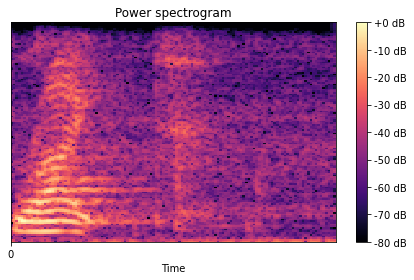

Spectogram of  ['right']


In [8]:
import matplotlib.pyplot as plt
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()
print('Spectogram of ', speech_data["label_vals"][rand])

In [9]:
## 1. Train/Test 데이터셋 구성하기

In [10]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [12]:
# spec을 split 해야되는데,,
from sklearn.model_selection import train_test_split

sr = 8000 # sampling rate : 1초동안 재생되는 샘플의 갯수
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 3.2701609e-03  4.7611231e-03  1.5359878e-04 ...  2.6396543e-03
   2.1570891e-03 -1.7878558e-03]
 [ 4.0343657e-05 -1.4804676e-05  3.0571180e-05 ...  2.1522475e-05
  -3.2043601e-05 -2.9217252e-05]
 [ 3.7469721e-04  3.8816416e-04  4.1144012e-04 ... -7.9477578e-04
   6.4808082e-05  2.7968455e-04]
 ...
 [ 3.7027991e-03  5.2611730e-03  5.2932923e-04 ...  3.7268675e-03
   3.2503358e-03 -4.8366608e-05]
 [-3.9884052e-03 -6.1671389e-03 -5.1798206e-03 ... -8.4393052e-03
  -8.3797267e-03 -7.4224821e-03]
 [ 6.4247958e-03  9.9033676e-03  5.3937305e-03 ... -3.3470455e-03
  -4.6551600e-03 -9.0670865e-03]]
✅


In [10]:
from sklearn.model_selection import train_test_split

sr = 8000 # sampling rate : 1초동안 재생되는 샘플의 갯수
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 3.29383928e-03  4.73430846e-03  8.27694748e-05 ...  2.58924044e-03
   2.09276122e-03 -1.84886344e-03]
 [-2.29994133e-02  1.17678530e-04 -4.60937440e-01 ... -7.03751504e-01
  -2.49979824e-01 -3.17300588e-01]
 [-1.45862938e-03 -1.73649527e-02 -2.27789413e-02 ... -1.83353685e-02
  -1.22006722e-02 -9.23804659e-03]
 ...
 [ 3.56650422e-03  5.10853110e-03  4.79863404e-04 ...  2.52311095e-03
   2.65214499e-03 -1.05743541e-03]
 [ 4.32836350e-05  9.03481632e-05  1.07116364e-04 ... -7.93207619e-06
  -1.22878526e-04 -1.98298920e-04]
 [-4.10460838e-04 -6.05964335e-04 -3.38721962e-04 ... -7.00858363e-04
  -4.21077508e-04 -4.36334492e-04]]
✅


In [11]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)
✅
